<a href="https://colab.research.google.com/github/DeDTihoN/PR_labs/blob/master/PR2_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота: OCR з використанням EMNIST

**Мета:** Порівняти кілька класичних алгоритмів та просту CNN для задачі розпізнавання рукописних літер **OCR** (EMNIST Letters).

---

## 1. Імпорт бібліотек

In [34]:
# Основні
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Для класичних методів
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog

# Для завантаження EMNIST
import tensorflow_datasets as tfds

# Для глибокої мережі
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

## 2. Завантаження й огляд EMNIST Letters

Повні розміри:
 Train: (88800, 28, 28) (88800,)
 Test : (14800, 28, 28) (14800,)


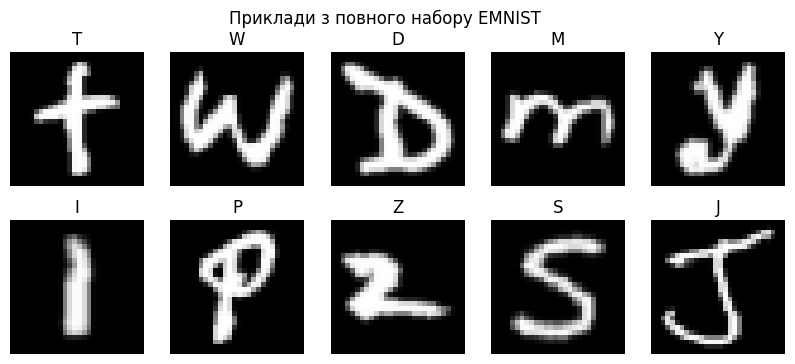

In [60]:
# Завантажуємо повні train та test піднабори
ds_train = tfds.load('emnist/letters', split='train', batch_size=-1, as_supervised=True)
ds_test  = tfds.load('emnist/letters', split='test',  batch_size=-1, as_supervised=True)
train_data = tfds.as_numpy(ds_train)
test_data  = tfds.as_numpy(ds_test)

# Розпаковуємо
X_full_train, y_full_train = train_data
X_full_test,  y_full_test  = test_data

# Видаляємо зайвий канал (1)
X_full_train = X_full_train.squeeze(-1)
X_full_test  = X_full_test.squeeze(-1)

# Переходимо від 1–26 до 0–25
y_full_train -= 1
y_full_test  -= 1

print('Повні розміри:')
print(' Train:', X_full_train.shape, y_full_train.shape)
print(' Test :', X_full_test.shape,  y_full_test.shape)

# Візуалізуємо приклади
fig, axes = plt.subplots(2, 5, figsize=(10,4))
idxs = np.random.choice(X_full_train.shape[0], 10, replace=False)
for ax, idx in zip(axes.flatten(), idxs):
    # EMNIST надається поверненим, тому транспонуємо для коректного відображення
    img = X_full_train[idx].T
    ax.imshow(img, cmap='gray')
    ax.set_title(chr(y_full_train[idx] + ord('A')))
    ax.axis('off')
plt.suptitle('Приклади з повного набору EMNIST')
plt.show()

## Формування піднаборів через train_test_split зі стратифікацією

In [37]:
from sklearn.model_selection import train_test_split

# Використовуємо train_test_split для вибірки 20000 тренувальних та 5000 тестових з гарантією представлення класів
X_train, X_test, y_train, y_test = train_test_split(
    X_full_train, y_full_train,
    train_size=15000,
    test_size=3500,
    stratify=y_full_train,
    random_state=42
)

print('Після підвибірки через train_test_split:')
print(' Train:', X_train.shape, y_train.shape)
print(' Test :', X_test.shape,  y_test.shape)

# Перевірка представлення всіх класів
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test,  counts_test  = np.unique(y_test,  return_counts=True)
print(f'У тренувальній вибірці знайдено класів: {len(unique_train)} / 26')
print(f'У тестовій вибірці знайдено класів: {len(unique_test)} / 26')

Після підвибірки через train_test_split:
 Train: (15000, 28, 28) (15000,)
 Test : (3500, 28, 28) (3500,)
У тренувальній вибірці знайдено класів: 26 / 26
У тестовій вибірці знайдено класів: 26 / 26


## Предобробка та екстракція HOG-фіч

In [38]:
# Підготовка плоского вигляду
X_train_flat = X_train.reshape(-1,28*28)
X_test_flat  = X_test.reshape(-1,28*28)

# Масштабування
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

# HOG-фічі
def extract_hog(X_flat):
    return np.array([
        hog(img.reshape(28,28), pixels_per_cell=(4,4), cells_per_block=(2,2), feature_vector=True)
        for img in X_flat
    ])

X_hog_train = extract_hog(X_train_scaled)
X_hog_test  = extract_hog(X_test_scaled)
print('Розмір HOG-фіч:', X_hog_train.shape)

Розмір HOG-фіч: (15000, 1296)


## Класичні методи: навчання та оцінка

--- Logistic Regression ---
Час навчання: 49.32 сек
Accuracy: 0.8463
              precision    recall  f1-score   support

           A       0.75      0.69      0.72       134
           B       0.92      0.89      0.90       134
           C       0.85      0.88      0.87       135
           D       0.83      0.83      0.83       134
           E       0.87      0.85      0.86       135
           F       0.84      0.84      0.84       134
           G       0.72      0.68      0.70       133
           H       0.86      0.87      0.87       135
           I       0.67      0.68      0.67       135
           J       0.83      0.81      0.82       134
           K       0.94      0.94      0.94       136
           L       0.66      0.66      0.66       135
           M       0.93      0.93      0.93       134
           N       0.89      0.84      0.86       133
           O       0.92      0.95      0.93       134
           P       0.95      0.93      0.94       135
           Q

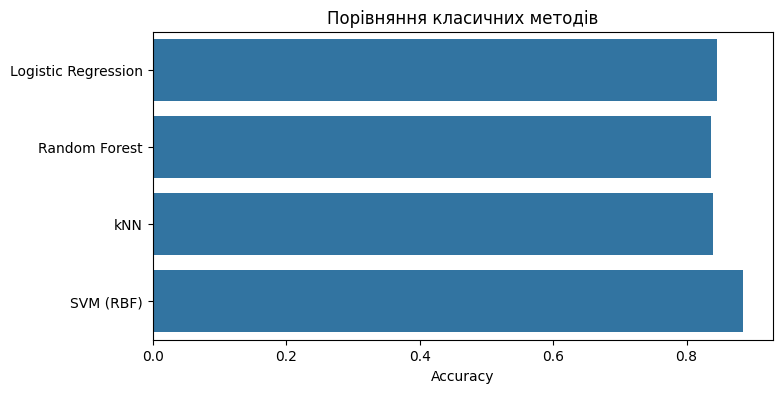

In [39]:
# Моделі
classical_models = {
    'Logistic Regression': LogisticRegression(max_iter=300, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', C=5, gamma=0.01, random_state=42)
}

results = {}
for name, model in classical_models.items():
    print(f"--- {name} ---")
    t0 = time.time()
    model.fit(X_hog_train, y_train)
    t1 = time.time()

    y_pred = model.predict(X_hog_test)
    acc = np.mean(y_pred == y_test)

    print(f"Час навчання: {t1 - t0:.2f} сек")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=[chr(i+ord('A')) for i in range(26)]))

    results[name] = {'pred': y_pred, 'accuracy': acc}

# Порівняння точностей
plt.figure(figsize=(8,4))
sns.barplot(x=[results[n]['accuracy'] for n in results], y=list(results.keys()))
plt.xlabel('Accuracy')
plt.title('Порівняння класичних методів')
plt.show()

## Матриці неточностей (Confusion Matrices)

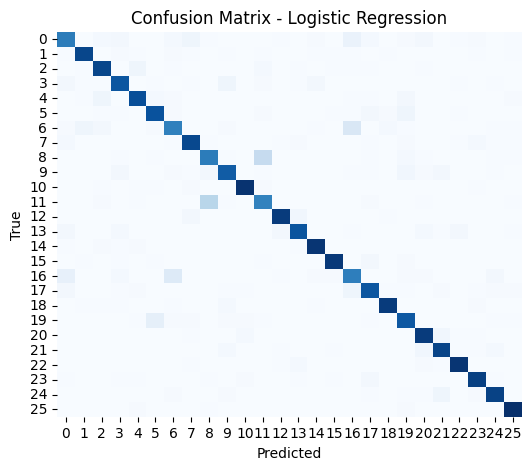

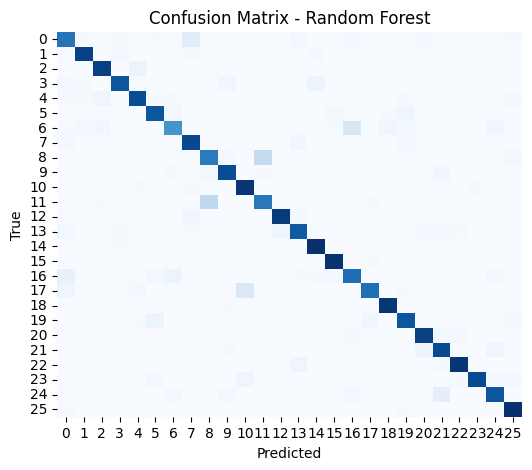

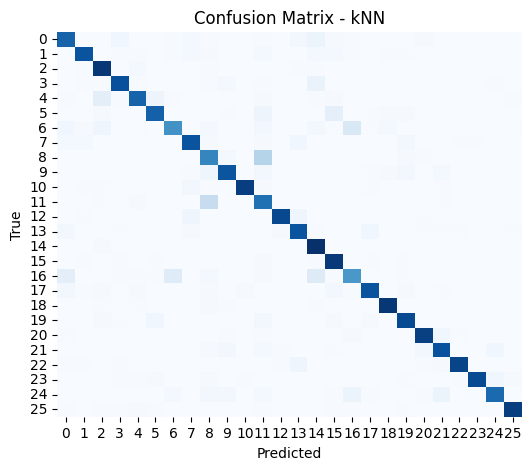

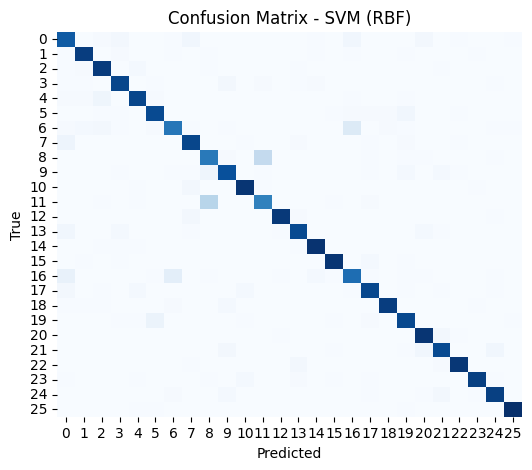

In [41]:
for name in results:
    cm = confusion_matrix(y_test, results[name]['pred'])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Типові помилки

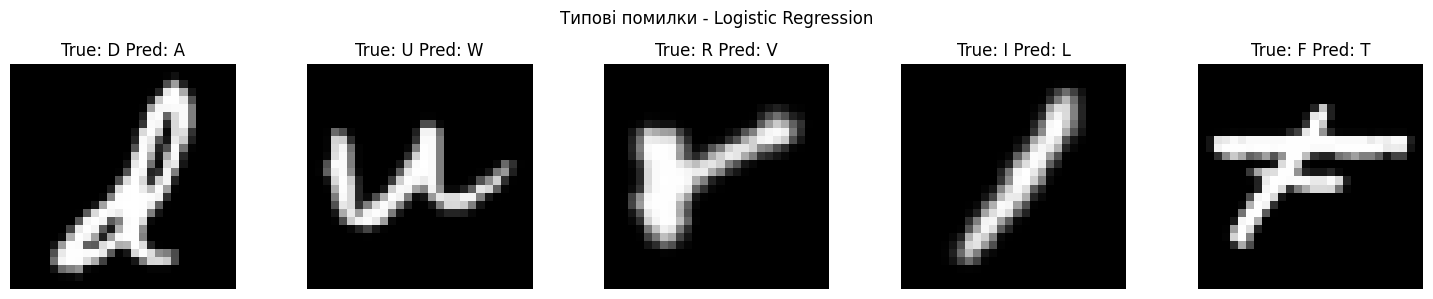

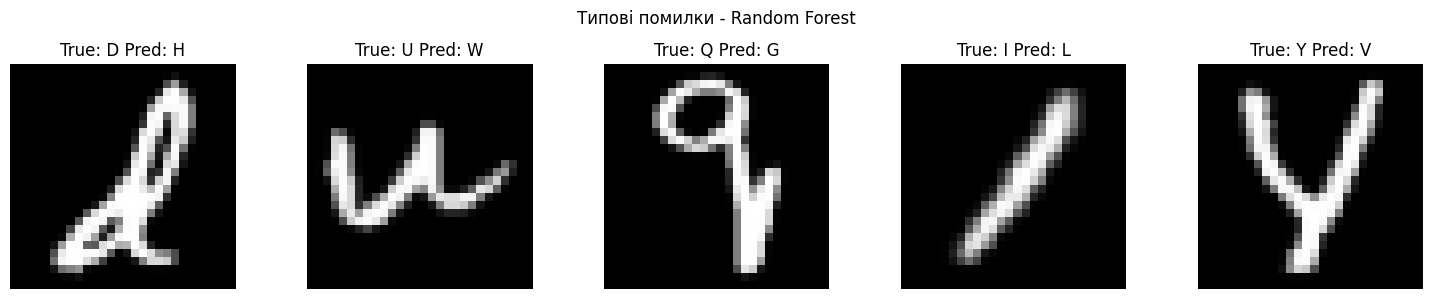

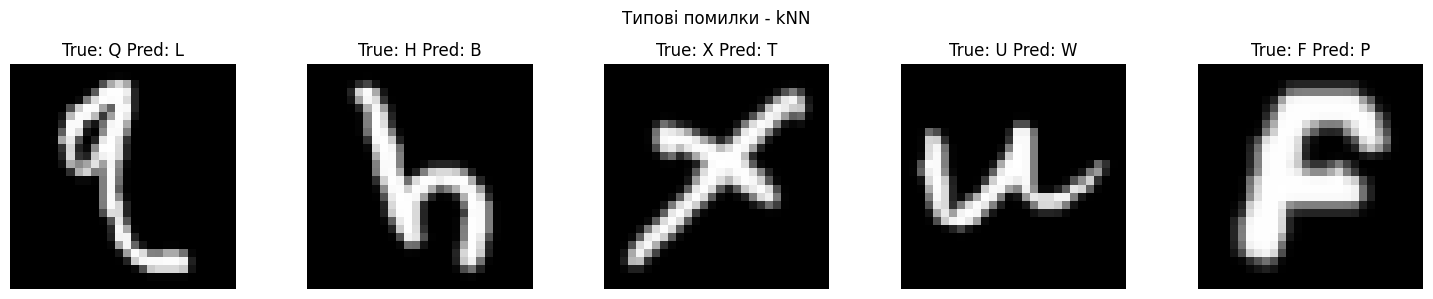

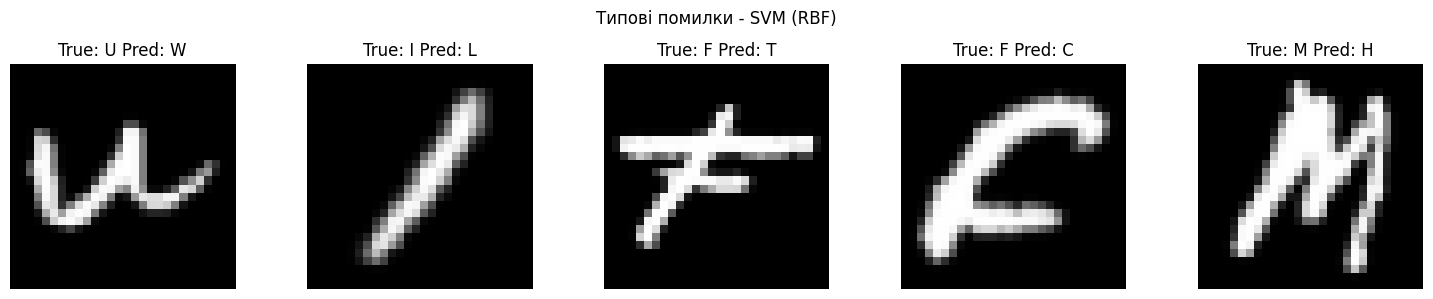

In [61]:
from matplotlib.gridspec import GridSpec

def plot_errors(X, y_true, y_pred, model_name, n=5):
    errors = np.where(y_pred != y_true)[0]
    plt.figure(figsize=(15,3))
    for i, idx in enumerate(errors[:n]):
        ax = plt.subplot(1, n, i+1)
        # Транспонуємо зображення для правильної орієнтації
        img = X[idx].T
        ax.imshow(img, cmap='gray')
        # Використовуємо escape-послідовність для переносу рядка
        title_str = f"True: {chr(y_true[idx] + ord('A'))} Pred: {chr(y_pred[idx] + ord('A'))}"
        ax.set_title(title_str)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.suptitle(f"Типові помилки - {model_name}")
    plt.show()

for name in results:
    plot_errors(X_test, y_test, results[name]['pred'], name)

## CNN для EMNIST

In [50]:
# Підготовка даних
X_train_cnn = X_train.reshape(-1,28,28,1)/255.0
X_test_cnn  = X_test.reshape(-1,28,28,1)/255.0

y_train_cat = to_categorical(y_train, num_classes=26)
y_test_cat  = to_categorical(y_test,  num_classes=26)

# Архітектура CNN
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Навчання з вимірюванням часу
start_time = time.time()
history = cnn.fit(
    X_train_cnn, y_train_cat,
    epochs=20, batch_size=128,
    validation_split=0.1,
    verbose=1
)
train_duration = time.time() - start_time
print(f"Час навчання CNN: {train_duration:.2f} сек")

# Прогноз
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)

# Оцінка
loss, acc = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"CNN Test accuracy після 20 епох: {acc:.4f}")

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2449 - loss: 2.6086 - val_accuracy: 0.7207 - val_loss: 0.9513
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6390 - loss: 1.1890 - val_accuracy: 0.7853 - val_loss: 0.6751
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7376 - loss: 0.8532 - val_accuracy: 0.8260 - val_loss: 0.5711
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7845 - loss: 0.6972 - val_accuracy: 0.8387 - val_loss: 0.4794
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8022 - loss: 0.6247 - val_accuracy: 0.8653 - val_loss: 0.4358
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8216 - loss: 0.5532 - val_accuracy: 0.8693 - val_loss: 0.3992
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8343 - loss: 0.5044 - val_accuracy: 0.8840 - val_loss: 0.3726
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8537 - loss: 0.4594 - val_accuracy: 0

## Графіки тренду точності (CNN)

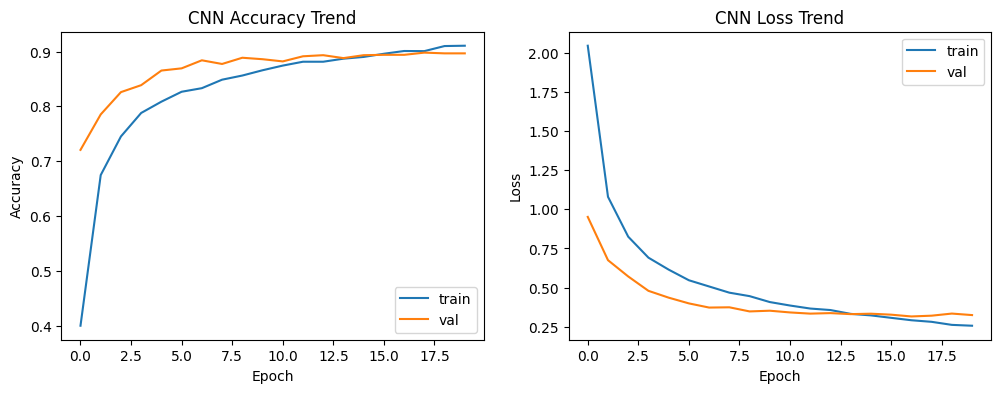

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('CNN Accuracy Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('CNN Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Матриця неточностей та типові помилки (CNN)

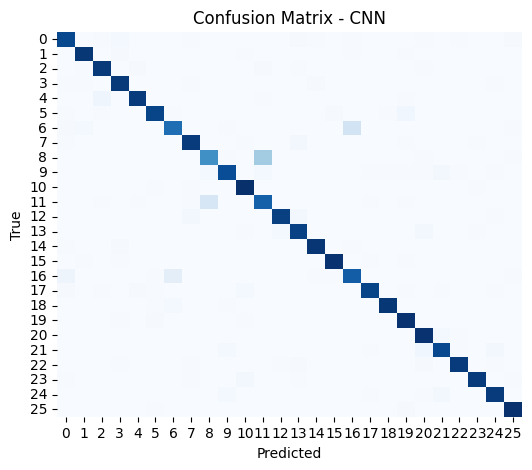

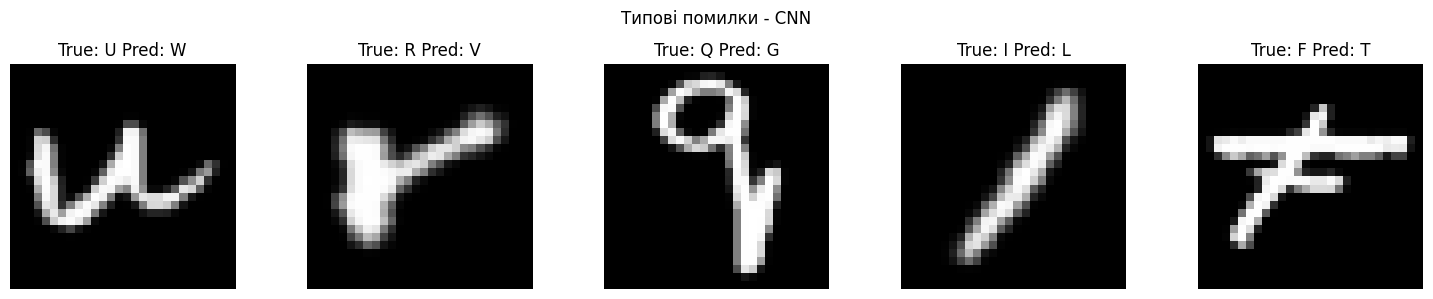

In [62]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, cmap='Blues', cbar=False)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plot_errors(X_test, y_test, y_pred_cnn, 'CNN')

- Здійснено підбір піднаборів з гарантією кожного класу.
- Проведено порівняння класичних методів за часом та точністю.
- Матриці неточностей та типові помилки відображено для всіх моделей .
- Побудовано графік тренду для CNN.
- CNN навчена на 20 епохах для стабілізації результату.|

| Модель                | Accuracy |
|-----------------------|----------|
| Logistic Regression   | 0.8463   |
| Random Forest         | 0.8360   |
| kNN                   | 0.8400   |
| SVM (RBF)             | 0.8849   |
| CNN (20 epochs)       | 0.9129   |

На основі отриманих результатів можемо зробити такі висновки:

1. **Швидкість навчання vs. точність:**
   - kNN — найшвидший у навчанні (~0.02 с), але має середню точність (0.8400). Підходить для невеликих датасетів без складної предобробки.
   - CNN — порівняно швидке навчання (17.38 с) та найвища точність (0.9129), демонструє оптимальний баланс.
   - Logistic Regression та Random Forest мають близьку точність (~0.84–0.85) і довший час тренування (49–51 с).
   - SVM з RBF-ядром показав високу точність (0.8849) за менший час (36.07 с) порівняно з Logistic Regression і Random Forest.

2. **Найкраща модель:**
   - **CNN** (0.9129) > SVM (RBF) (0.8849) > Logistic Regression (0.8463) ≈ kNN (0.8400) > Random Forest (0.8360).
   - CNN демонструє суттєву перевагу завдяки здатності автоматично вивчати репрезентативні фічі у процесі навчання.

3. **Матриці неточностей та типові помилки:**
   - Класичні моделі мають найбільше неправильних класифікацій між схожими літерами (наприклад, O та Q, C та G).
   - CNN краще розрізняє тонкі відмінності контурів, що мінімізує такі помилки.